1.1 Load and Initial Assessment

pip3 install pandas / install pandas

pip3 install numpy / install numpy

pandas documentation: https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')

print("Dataset Shape:", df.shape)
print("\n" + "="*50)

print("Dataset Info:")
print(df.info()) # Displaying the structure of the DataFrame
print("\n" + "="*50)

print("Statistical Summary:")
print(df.describe(include='all')) # Displaying summary statistics
print("\n" + "="*50)

print("Missing Values:") 
print(df.isnull().sum()) # Displaying the count of missing values
print("\n" + "="*50)

print("Duplicate Rows:", df.duplicated().sum())

Dataset Shape: (1067371, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None

Statistical Summary:
        Invoice StockCode                         Description      Quantity  \
count   1067371   1067371                             1062989  1.067371e+06   
unique    53628      5305                                5698           NaN   
top      537434    85123A  WHITE HANGING HEART T-LIGHT HOLDER           NaN   

1.2 Data Cleaning

In [5]:

# Data Cleaning Steps
df_clean = df.copy()

# Step 1: Remove duplicates
print(f"Original shape: {df_clean.shape}")
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

# Step 2: Handle cancelled orders (Invoice starting with 'C')
cancelled_orders = df_clean[df_clean['Invoice'].astype(str).str.startswith('C')]
print(f"Cancelled orders found: {len(cancelled_orders)}")
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
print(f"After removing cancelled orders: {df_clean.shape}")

# Step 3: Remove records with zero or negative price
print(f"Records with price <= 0: {(df_clean['Price'] <= 0).sum()}")
df_clean = df_clean[df_clean['Price'] > 0]
print(f"After removing zero/negative prices: {df_clean.shape}")

# Step 4: Remove records with zero or negative quantity
print(f"Records with quantity <= 0: {(df_clean['Quantity'] <= 0).sum()}")
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"After removing zero/negative quantities: {df_clean.shape}")

# Step 5: Handle missing Customer IDs
print(f"Missing Customer IDs: {df_clean['Customer ID'].isnull().sum()}")
# For RFM analysis, we need Customer ID, so we'll create two datasets
df_with_customers = df_clean.dropna(subset=['Customer ID']).copy()
print(f"Dataset with Customer IDs: {df_with_customers.shape}")

# Step 6: Remove non-product stock codes
non_product_codes = ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']
df_clean = df_clean[~df_clean['StockCode'].isin(non_product_codes)]
df_with_customers = df_with_customers[~df_with_customers['StockCode'].isin(non_product_codes)]
print(f"After removing non-product codes: {df_clean.shape}")

Original shape: (1067371, 8)
After removing duplicates: (1033036, 8)
Cancelled orders found: 19104
After removing cancelled orders: (1013932, 8)
Records with price <= 0: 6019
After removing zero/negative prices: (1007913, 8)
Records with quantity <= 0: 0
After removing zero/negative quantities: (1007913, 8)
Missing Customer IDs: 228488
Dataset with Customer IDs: (779425, 8)
After removing non-product codes: (1003478, 8)


1.3 Feature Engineering

In [ ]:
# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']
df_with_customers['TotalPrice'] = df_with_customers['Quantity'] * df_with_customers['Price']

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_with_customers['InvoiceDate'] = pd.to_datetime(df_with_customers['InvoiceDate'])

# Extract temporal features
for df_temp in [df_clean, df_with_customers]:
    df_temp['Year'] = df_temp['InvoiceDate'].dt.year
    df_temp['Month'] = df_temp['InvoiceDate'].dt.month
    df_temp['Day'] = df_temp['InvoiceDate'].dt.day
    df_temp['DayOfWeek'] = df_temp['InvoiceDate'].dt.dayofweek
    df_temp['DayName'] = df_temp['InvoiceDate'].dt.day_name()
    df_temp['HourOfDay'] = df_temp['InvoiceDate'].dt.hour
    df_temp['YearMonth'] = df_temp['InvoiceDate'].dt.to_period('M')

# Convert Customer ID to integer (for df_with_customers)
df_with_customers['Customer ID'] = df_with_customers['Customer ID'].astype(int)

print("Data preprocessing completed!")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Dataset with customers shape: {df_with_customers.shape}")

Data preprocessing completed!
Final dataset shape: (1003478, 16)
Dataset with customers shape: (776624, 16)


2.1 Temporal Analysis

import matplotlib.pyplot as plt

matplotlib documentation: https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html

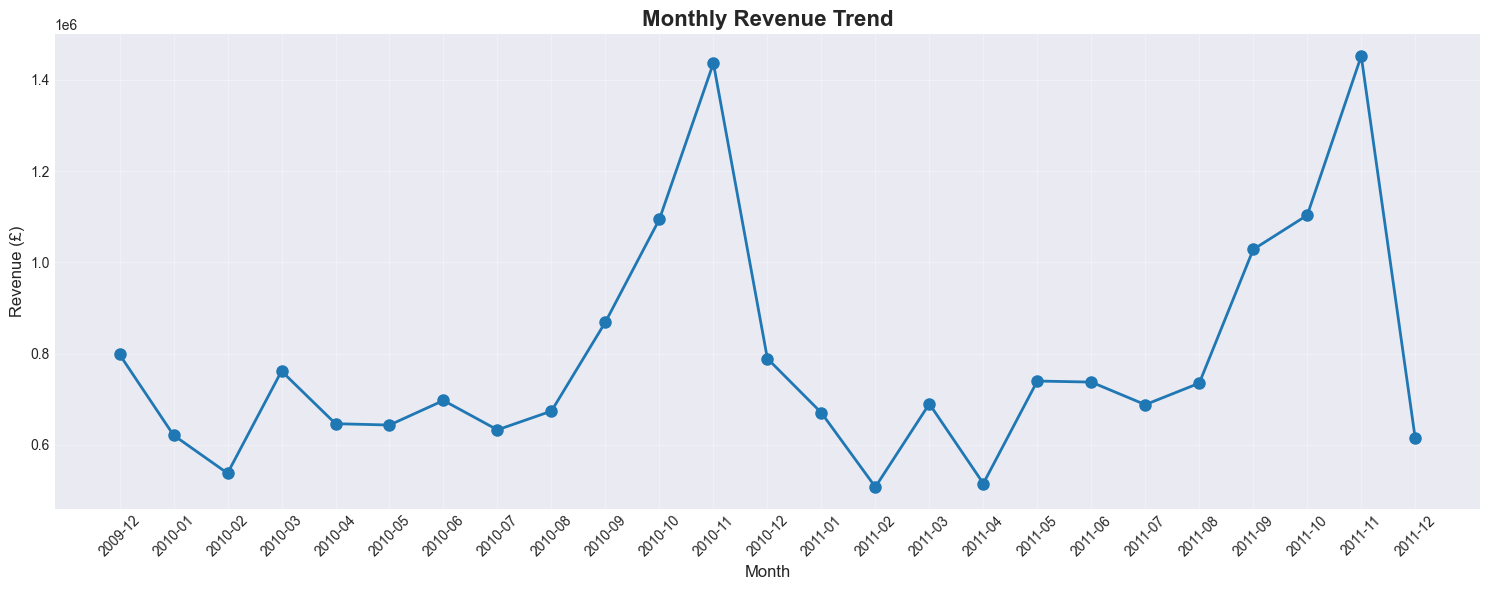

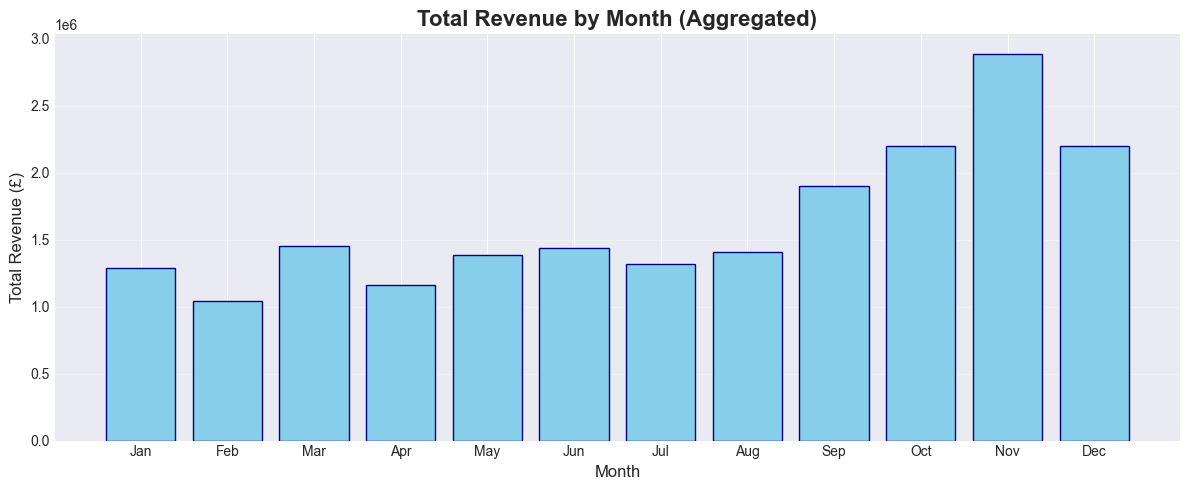

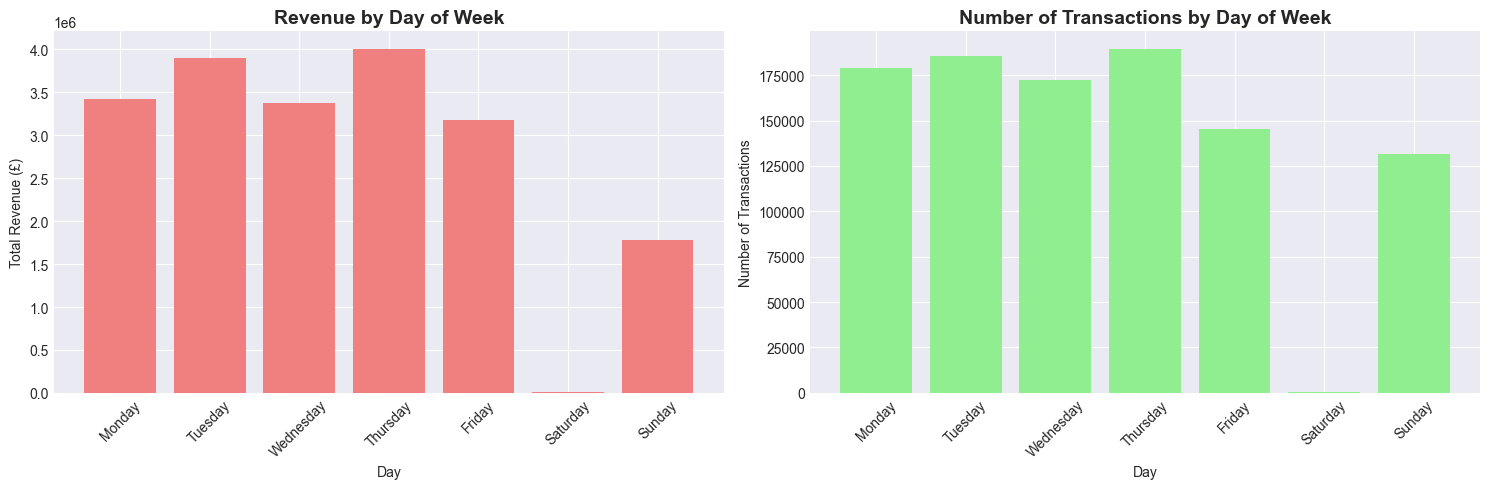

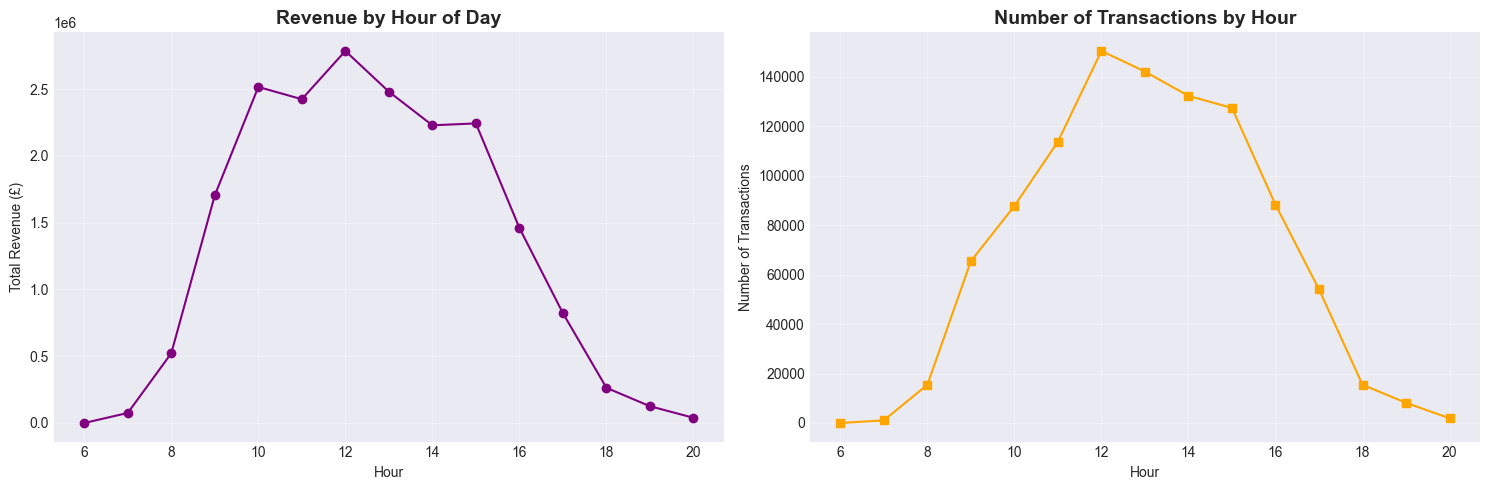

In [10]:
import matplotlib.pyplot as plt
# Set the style for the plots

plt.style.use('seaborn-v0_8-darkgrid')

# Ensure InvoiceDate is datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create TotalPrice column (Quantity × Price)
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# Create YearMonth column
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')

# Extract Month number
df_clean['Month'] = df_clean['InvoiceDate'].dt.month

# Extract Day of Week name
df_clean['DayName'] = df_clean['InvoiceDate'].dt.day_name()

# Extract Hour of Day
df_clean['HourOfDay'] = df_clean['InvoiceDate'].dt.hour



# Monthly Revenue Trend
monthly_revenue = df_clean.groupby('YearMonth')['TotalPrice'].sum().reset_index()
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].astype(str)

plt.figure(figsize=(15, 6))
plt.plot(monthly_revenue['YearMonth'], monthly_revenue['TotalPrice'], marker='o', linewidth=2, markersize=8)
plt.title('Monthly Revenue Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify seasonal patterns
monthly_avg = df_clean.groupby('Month')['TotalPrice'].agg(['sum', 'mean', 'count'])
monthly_avg['avg_per_transaction'] = monthly_avg['sum'] / monthly_avg['count']

plt.figure(figsize=(12, 5))
plt.bar(monthly_avg.index, monthly_avg['sum'], color='skyblue', edgecolor='navy')
plt.title('Total Revenue by Month (Aggregated)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Day of Week Analysis
day_analysis = df_clean.groupby('DayName')['TotalPrice'].agg(['sum', 'count', 'mean'])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_analysis = day_analysis.reindex(day_order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(day_analysis.index, day_analysis['sum'], color='lightcoral')
ax1.set_title('Revenue by Day of Week', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Revenue (£)')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(day_analysis.index, day_analysis['count'], color='lightgreen')
ax2.set_title('Number of Transactions by Day of Week', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day')
ax2.set_ylabel('Number of Transactions')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Hour of Day Analysis
hour_analysis = df_clean.groupby('HourOfDay')['TotalPrice'].agg(['sum', 'count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(hour_analysis.index, hour_analysis['sum'], marker='o', color='purple')
ax1.set_title('Revenue by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Total Revenue (£)')
ax1.grid(True, alpha=0.3)

ax2.plot(hour_analysis.index, hour_analysis['count'], marker='s', color='orange')
ax2.set_title('Number of Transactions by Hour', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Number of Transactions')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2.2 Geographic Analysis


UK Revenue: £16,842,025.74 (85.5%)
International Revenue: £2,845,128.79 (14.5%)


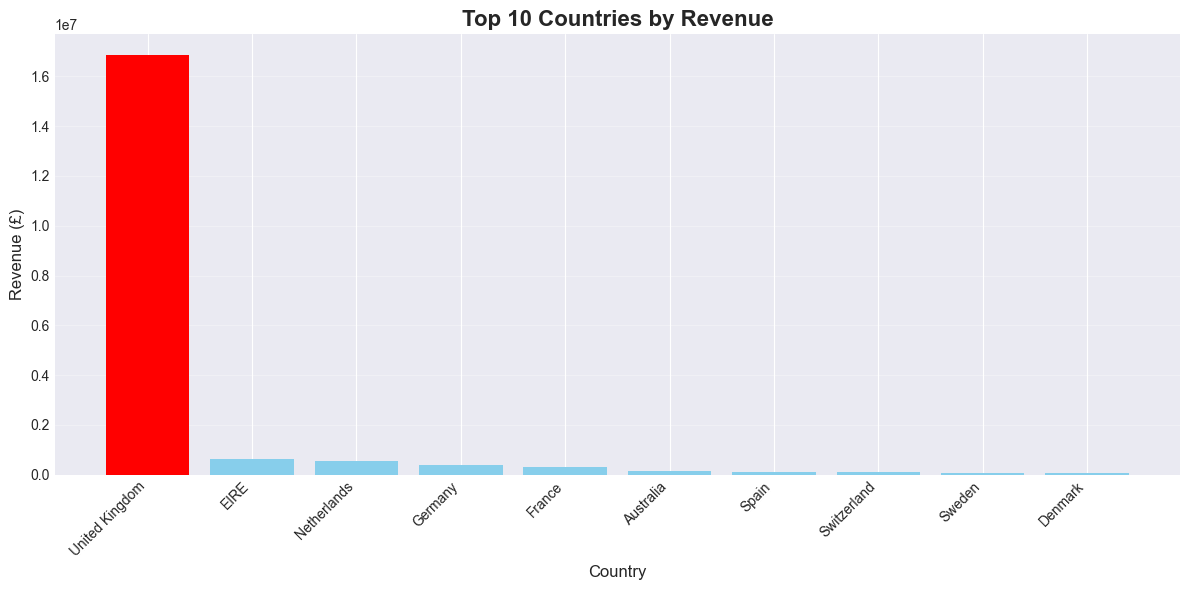

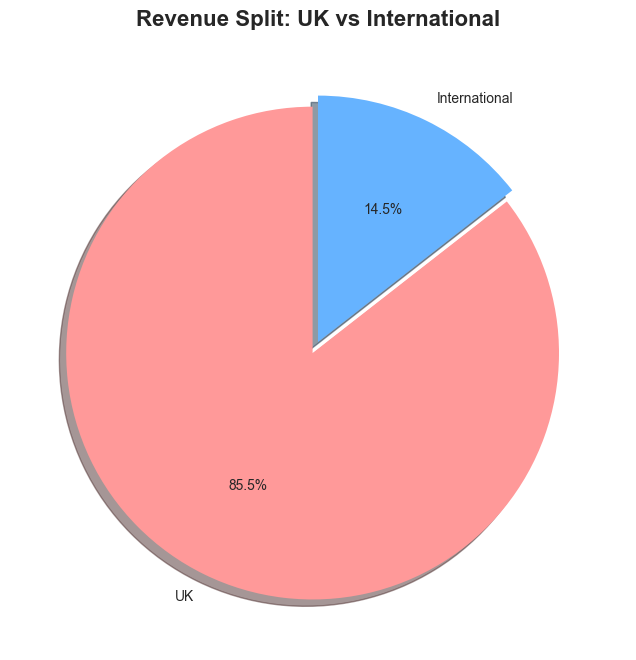

In [11]:
# Top 10 countries by revenue
country_revenue = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
top10_countries = country_revenue.head(10)

# Calculate UK vs International split
uk_revenue = country_revenue['United Kingdom'] if 'United Kingdom' in country_revenue.index else 0
international_revenue = country_revenue.sum() - uk_revenue
uk_percentage = (uk_revenue / country_revenue.sum()) * 100

print(f"UK Revenue: £{uk_revenue:,.2f} ({uk_percentage:.1f}%)")
print(f"International Revenue: £{international_revenue:,.2f} ({100-uk_percentage:.1f}%)")

# Visualize top 10 countries
plt.figure(figsize=(12, 6))
colors = ['red' if x == 'United Kingdom' else 'skyblue' for x in top10_countries.index]
plt.bar(range(len(top10_countries)), top10_countries.values, color=colors)
plt.title('Top 10 Countries by Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(range(len(top10_countries)), top10_countries.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Create pie chart for UK vs International
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [uk_revenue, international_revenue]
labels = ['UK', 'International']
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0)

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Revenue Split: UK vs International', fontsize=16, fontweight='bold')
plt.show()

2.3 Product Performance Analysis


Top 10 Products by Quantity Sold:
StockCode                        Description  Quantity
    84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS    106139
   85123A WHITE HANGING HEART T-LIGHT HOLDER     94142
    23843        PAPER CRAFT , LITTLE BIRDIE     80995
    84879      ASSORTED COLOUR BIRD ORNAMENT     80082
    23166     MEDIUM CERAMIC TOP STORAGE JAR     78033
   85099B            JUMBO BAG RED RETROSPOT     77280
    17003                BROCADE RING PURSE      70369
    21977 PACK OF 60 PINK PAISLEY CAKE CASES     56061
    84991        60 TEATIME FAIRY CAKE CASES     54028
    22197               SMALL POPCORN HOLDER     48561

Top 10 Products by Revenue:
StockCode                         Description  TotalPrice
    22423            REGENCY CAKESTAND 3 TIER   330590.32
   85123A  WHITE HANGING HEART T-LIGHT HOLDER   257546.20
    23843         PAPER CRAFT , LITTLE BIRDIE   168469.60
    47566                       PARTY BUNTING   148318.28
   85099B             JUMBO BAG RED RETROS

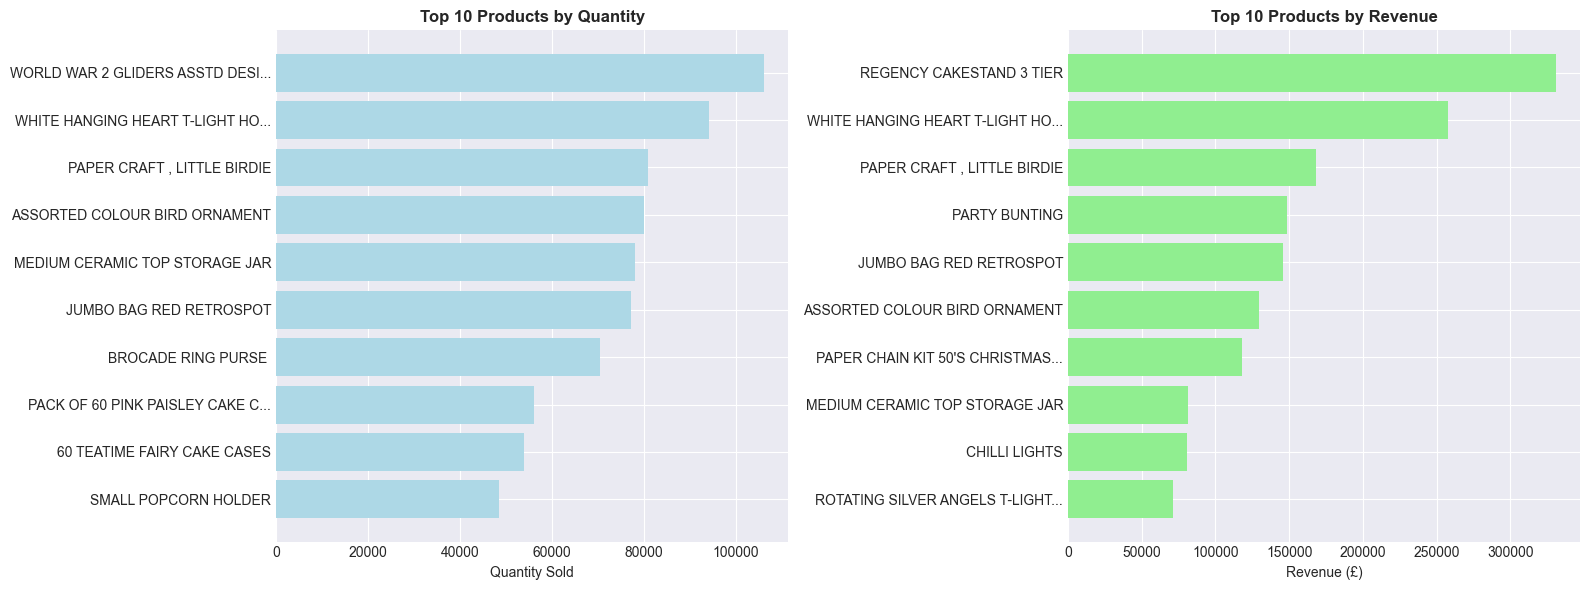


Products appearing in both lists: 5
Products unique to quantity list: 5
Products unique to revenue list: 5


In [12]:
# Top 10 Products by Quantity
product_quantity = df_clean.groupby(['StockCode', 'Description'])['Quantity'].sum().sort_values(ascending=False)
top10_quantity = product_quantity.head(10).reset_index()

print("Top 10 Products by Quantity Sold:")
print(top10_quantity.to_string(index=False))
print("\n" + "="*50)

# Top 10 Products by Revenue
product_revenue = df_clean.groupby(['StockCode', 'Description'])['TotalPrice'].sum().sort_values(ascending=False)
top10_revenue = product_revenue.head(10).reset_index()

print("Top 10 Products by Revenue:")
print(top10_revenue.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Quantity chart
ax1.barh(range(10), top10_quantity['Quantity'].values, color='lightblue')
ax1.set_yticks(range(10))
ax1.set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc 
                      for desc in top10_quantity['Description']])
ax1.set_xlabel('Quantity Sold')
ax1.set_title('Top 10 Products by Quantity', fontweight='bold')
ax1.invert_yaxis()

# Revenue chart
ax2.barh(range(10), top10_revenue['TotalPrice'].values, color='lightgreen')
ax2.set_yticks(range(10))
ax2.set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc 
                      for desc in top10_revenue['Description']])
ax2.set_xlabel('Revenue (£)')
ax2.set_title('Top 10 Products by Revenue', fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Analysis of overlap between the two lists
quantity_products = set(top10_quantity['StockCode'])
revenue_products = set(top10_revenue['StockCode'])
overlap = quantity_products.intersection(revenue_products)

print(f"\nProducts appearing in both lists: {len(overlap)}")
print(f"Products unique to quantity list: {len(quantity_products - revenue_products)}")
print(f"Products unique to revenue list: {len(revenue_products - quantity_products)}")